## Dataset Au-Au: ponta de ouro e substrato de ouro
### Teste 15 - 2x2, séries temporais cortadas em t=400, `grid_eight`, 100 séries temporais.
### Importando bibliotecas e dados

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matrixprofile import matrixProfile, motifs
from pyclustering.nnet.som import type_conn
import math
import os
import sys
sys.path.insert(0, os.path.abspath('../src'))
import dtwsom

In [2]:
D3011_data = np.load('dataset_TipAu_Au.npz')

In [3]:
D3011_data.keys()

KeysView(NpzFile 'dataset_TipAu_Au.npz' with keys: smoothedMeasuredHeight_m, vDeflection_N, height_m, measuredHeight_m, seriesTime_s...)

In [4]:
list(D3011_data.keys())

['smoothedMeasuredHeight_m',
 'vDeflection_N',
 'height_m',
 'measuredHeight_m',
 'seriesTime_s',
 'time_s']

In [5]:
force_data = D3011_data['vDeflection_N']

In [6]:
force_data.shape

(1024, 800)

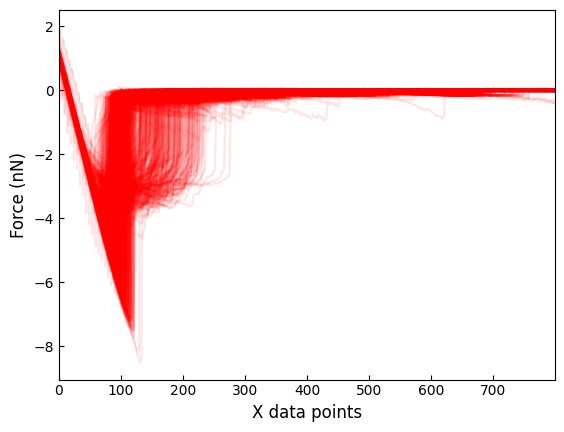

In [7]:
fig,ax = plt.subplots(dpi=100)

for curve in force_data:
    ax.plot(curve,c='red',alpha=0.1)

ax.set_xlabel('X data points',fontsize=12)
ax.set_ylabel('Force (nN)',fontsize=12)

ax.tick_params(labelsize=10,direction='in')

ax.set_xlim([0,force_data.shape[1]-1])

#fig.savefig('../data/figures/pca_examples/D3011_curves.png',dpi=300,bbox_inches='tight')

plt.show()

### Split dos dados

Para essa clusterização, foram selecionados as **primeiras 100 curvas** do *dataset*.

In [8]:
train_set = force_data[:100]
test_set = force_data[100:]

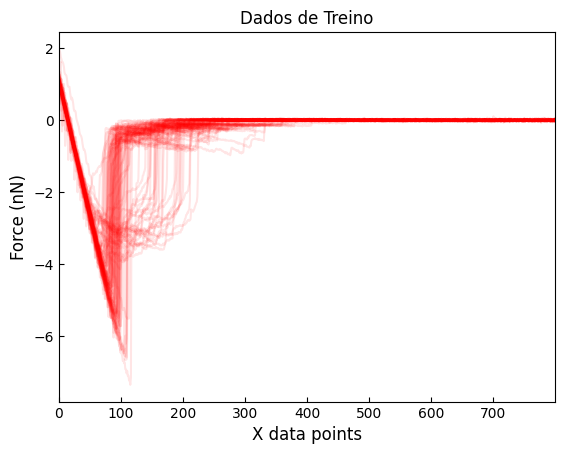

In [9]:
fig,ax = plt.subplots(dpi=100)

for curve in train_set:
    ax.plot(curve,c='red',alpha=0.1)

ax.set_xlabel('X data points',fontsize=12)
ax.set_ylabel('Force (nN)',fontsize=12)

ax.tick_params(labelsize=10,direction='in')

ax.set_xlim([0,force_data.shape[1]-1])

ax.set_title("Dados de Treino")

#fig.savefig('../data/figures/pca_examples/D3011_curves.png',dpi=300,bbox_inches='tight')

plt.show()

In [10]:
len(train_set[0])

800

In [11]:
train_set_cort = np.zeros((100,400))

for i in range(len(train_set_cort)):
    train_set_cort[i] = train_set[i][:400]

train_set_cort

array([[ 1.9760933e+00,  1.9316160e+00,  1.8887263e+00, ...,
        -3.8840400e-02, -7.2704577e-03, -2.4726651e-02],
       [ 1.2385187e+00,  1.1436823e+00,  1.0508256e+00, ...,
        -2.0990171e-02, -2.0955503e-02, -1.5252194e-02],
       [ 9.9519460e-01,  8.9909390e-01,  8.4386265e-01, ...,
        -1.1813284e-02, -4.9911630e-04, -2.4743641e-02],
       ...,
       [ 1.0334559e+00,  1.1225892e+00,  9.6069340e-01, ...,
         1.1472524e-03,  1.9971315e-02, -7.5635100e-03],
       [ 9.9495860e-01,  9.6008700e-01,  9.5344280e-01, ...,
         5.1586100e-03, -1.4277684e-03, -1.4681560e-02],
       [ 1.1985062e+00,  1.0841645e+00,  1.0030030e+00, ...,
        -3.0604456e-02,  9.6067690e-03, -1.9850345e-02]])

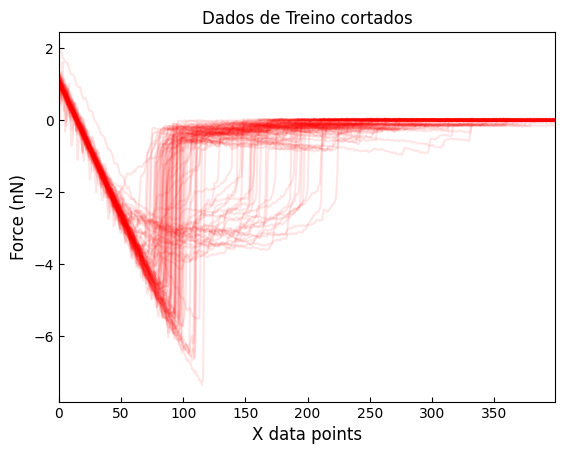

In [12]:
fig,ax = plt.subplots(dpi=100)

for curve in train_set_cort:
    ax.plot(curve,c='red',alpha=0.1)

ax.set_xlabel('X data points',fontsize=12)
ax.set_ylabel('Force (nN)',fontsize=12)

ax.tick_params(labelsize=10,direction='in')

ax.set_xlim([0,train_set_cort.shape[1]-1])

ax.set_title("Dados de Treino cortados")

#fig.savefig('../data/figures/pca_examples/D3011_curves.png',dpi=300,bbox_inches='tight')

plt.show()

### Concatenando os dados e descobrindo motifs
Todas as curvas foram concatenadas em uma única série temporal, como indicado no artigo de base, do desenvolvimento do método DTW-SOM.

In [13]:
size = len(train_set_cort[0])
sample_size = len(train_set_cort)
print(size, sample_size)

400 100


In [14]:
joined_data = train_set_cort[0]
for i in range(1, sample_size):
    joined_data = np.concatenate((joined_data, train_set_cort[i]))
len(joined_data)

40000

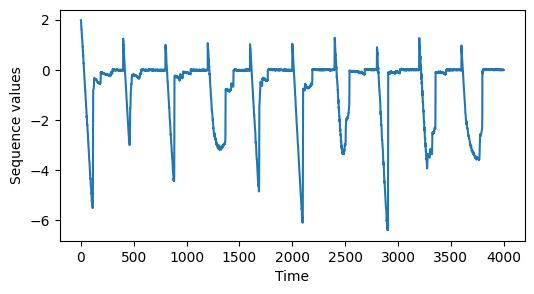

In [15]:
plt.figure(figsize=(6,3))
plt.plot(np.arange(4000), joined_data[:4000])
plt.ylabel("Sequence values")
plt.xlabel("Time")
plt.show()

In [16]:
%%time
mp = matrixProfile.stomp(joined_data, size)

CPU times: user 11.8 s, sys: 16.2 ms, total: 11.8 s
Wall time: 11.8 s


In [17]:
print(mp[1])

[11987. 11988. 11989. ... 25997. 25998. 25999.]


Somando uma matriz de zeros à matriz de perfil, assim, os valores de `Nan` se tornam numéricos e iguais a zero.

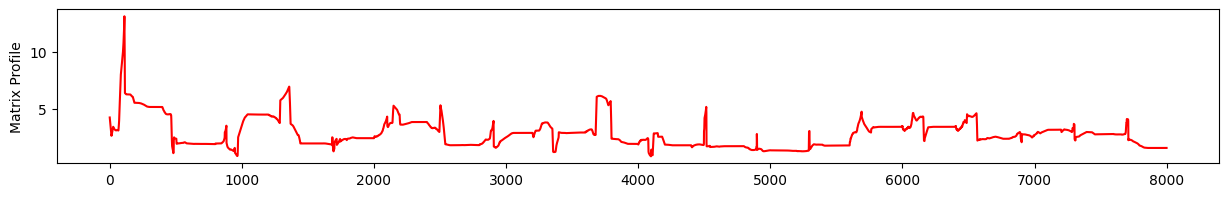

In [18]:
mp_adj = np.append(mp[0],np.zeros(size-1)+np.nan)

plt.figure(figsize=(15,2))
plt.plot(np.arange(8000), mp_adj[:8000], color='red')
plt.ylabel("Matrix Profile")
plt.show()

Extraindo os motifs.

In [19]:
%%time
mtfs, motif_d  = motifs.motifs(joined_data, mp, max_motifs=1000)
len(mtfs)

CPU times: user 98.2 ms, sys: 31.8 ms, total: 130 ms
Wall time: 97.2 ms


45

Criando uma lista com os centros de motifs.

In [20]:
motif_center_list = []
for motif in mtfs:
    center_pointers = list(np.arange(motif[0], motif[0]+size))
    motif_center = joined_data[center_pointers]
    motif_center_list.append(motif_center)

len(joined_data)

40000

In [21]:
len(motif_center_list)

45

### Treinando a rede DTW-SOM

In [22]:
%time
rows = 2
cols = 2
structure = type_conn.grid_eight
network = dtwsom.DtwSom(rows, cols, structure)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 4.29 µs


In [23]:
%%time
network.train(motif_center_list, 50)

Epoch 1 achieved an average quantization error of 9.072
Epoch 2 achieved an average quantization error of 12.83
Epoch 3 achieved an average quantization error of 12.8818
Epoch 4 achieved an average quantization error of 12.9044
Epoch 5 achieved an average quantization error of 12.7481
Epoch 6 achieved an average quantization error of 12.8674
Epoch 7 achieved an average quantization error of 12.7703
Epoch 8 achieved an average quantization error of 12.7505
Epoch 9 achieved an average quantization error of 12.7293
Epoch 10 achieved an average quantization error of 12.6272
Epoch 11 achieved an average quantization error of 12.3932
Epoch 12 achieved an average quantization error of 11.3854
Epoch 13 achieved an average quantization error of 9.4423
Epoch 14 achieved an average quantization error of 8.6897
Epoch 15 achieved an average quantization error of 8.6711
Epoch 16 achieved an average quantization error of 8.584
Epoch 17 achieved an average quantization error of 8.5324
Epoch 18 achieve

50

### Resultados

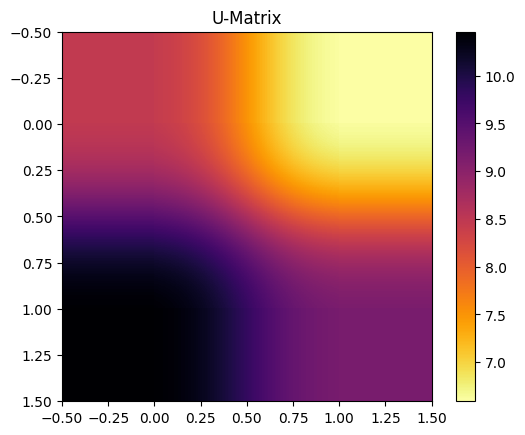

In [24]:
network.show_distance_matrix()

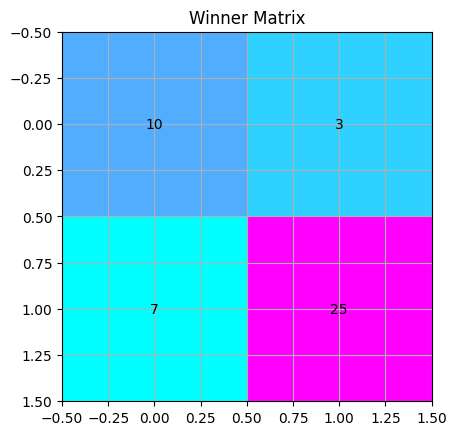

In [25]:
network.show_winner_matrix()

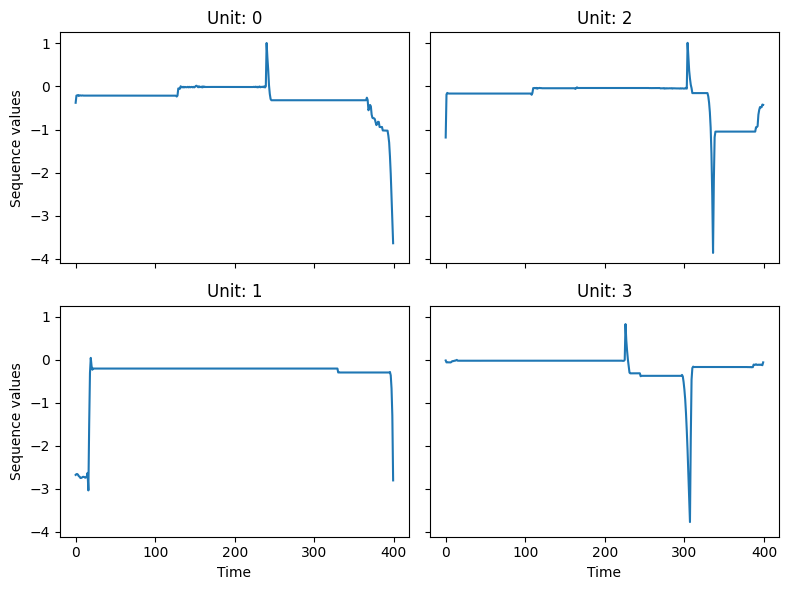

In [26]:
n_neurons = network._size
fig, axs = plt.subplots(2,2,figsize=(8, 6), sharex=True, sharey=True)
for neuron_index in range(n_neurons):
    col = math.floor(neuron_index/2) # round numbers down to the nearest integer:
    #math.ceil: round a number UP to the nearest integer
    row = neuron_index % 2
    neuron_weights = network._weights[neuron_index]
    axs[row, col].plot(np.arange(len(neuron_weights)), neuron_weights, label=str(neuron_index))
    axs[row, col].set_title("Unit: "+str(neuron_index))
    if col == 0:
        axs[row, col].set_ylabel("Sequence values")
    if row == 1:
        axs[row, col].set_xlabel("Time")
plt.tight_layout()
plt.show()

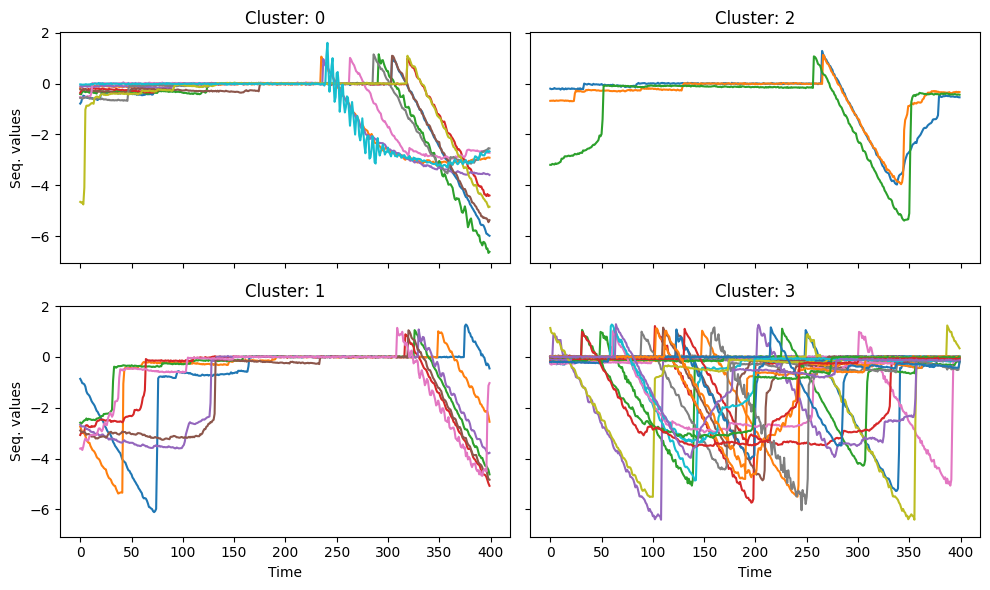

In [27]:
n = rows
n_neurons = network._size
fig, axs = plt.subplots(n,n,figsize=(10, 6), sharex=True, sharey=True)
for neuron_index in range(n_neurons):
    col = math.floor(neuron_index/n)
    row = neuron_index % n
    cluster_list = network.capture_objects[neuron_index]
    for member_index in cluster_list:
        axs[row, col].plot(np.arange(len(motif_center_list[member_index])), motif_center_list[member_index])
    axs[row, col].set_title("Cluster: "+str(neuron_index))
    if col == 0:
        axs[row, col].set_ylabel("Seq. values")
    if row == 1:
        axs[row, col].set_xlabel("Time")
plt.tight_layout()
plt.show()

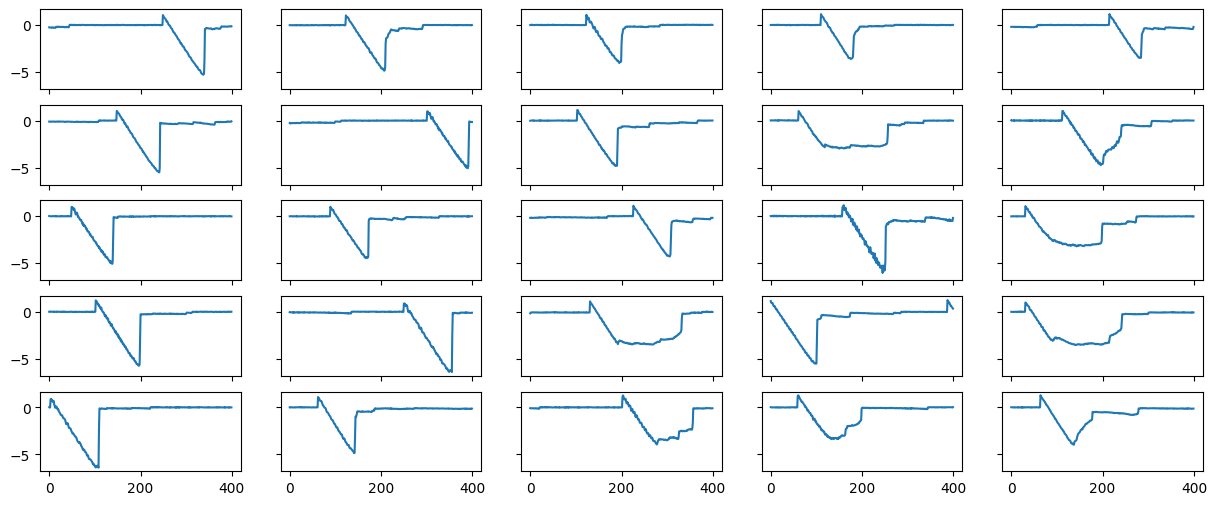

In [31]:
fig, axs = plt.subplots(5, 5, figsize=(15, 6), sharex=True, sharey=True)
cluster_list = network.capture_objects[3]
for i, member_index in enumerate(cluster_list):
    col = math.floor(i/5)
    row = i % 5
    axs[row, col].plot(np.arange(len(motif_center_list[member_index])), motif_center_list[member_index])
plt.show()